In [5]:
import os
import cv2
import numpy as np
import math
import mediapipe as mp
from matplotlib import pyplot as plt
import glob
from util.img2bone import HandDetector
import os
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
import glob
import numpy as np
from tqdm.auto import tqdm

from loader.dataloader import SkeletonAndEMGData

In [6]:
def find_adjacency_matrix():
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()
    adj = torch.zeros((21,21))
    for connection in mp_hands.HAND_CONNECTIONS:
        adj[connection[0],connection[1]] = 1
        adj[connection[1],connection[0]] = 1
    return adj 

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class GraphConvolution(nn.Module):
	def __init__(self, input_dim, output_dim, num_vetex, act=F.relu, dropout=0.5, bias=True):
		super(GraphConvolution, self).__init__()

		self.alpha = 1.

		self.act = act
		self.dropout = nn.Dropout(dropout)
		self.weight = nn.Parameter(torch.randn(input_dim, output_dim)).to(device)
		if bias:
			self.bias = nn.Parameter(torch.randn(output_dim)).to(device)
		else:
			self.bias = None

		for w in [self.weight]:
			nn.init.xavier_normal_(w)

	def normalize(self, m):
		rowsum = torch.sum(m, 0)
		r_inv = torch.pow(rowsum, -0.5)
		r_mat_inv = torch.diag(r_inv).float()

		m_norm = torch.mm(r_mat_inv, m)
		m_norm = torch.mm(m_norm, r_mat_inv)

		return m_norm

	def forward(self, adj, x):

		x = self.dropout(x)

		# K-ordered Chebyshev polynomial
		adj_norm = self.normalize(adj)
		sqr_norm = self.normalize(torch.mm(adj,adj))
		m_norm = (self.alpha*adj_norm + (1.-self.alpha)*sqr_norm).to(device)

		x_tmp = torch.einsum('abcd,de->abce', x, self.weight)
		x_out = torch.einsum('ij,abid->abjd', m_norm, x_tmp)
		if self.bias is not None:
			x_out += self.bias
		x_out = self.act(x_out)
  
		
		return x_out
		
		

class StandConvolution(nn.Module):
	def __init__(self, dims, num_classes, dropout):
		super(StandConvolution, self).__init__()

		self.dropout = nn.Dropout(dropout)
		self.conv = nn.Sequential(
								   nn.Conv2d(dims[0], dims[1], kernel_size=5, stride=2),
								   nn.InstanceNorm2d(dims[1]),
								   nn.ReLU(inplace=True),
								   #nn.AvgPool2d(3, stride=2),
								   nn.Conv2d(dims[1], dims[2], kernel_size=5, stride=2),
								   nn.InstanceNorm2d(dims[2]),
								   nn.ReLU(inplace=True),
								   #nn.AvgPool2d(3, stride=2),
								   nn.Conv2d(dims[2], dims[3], kernel_size=5, stride=2),
								   nn.InstanceNorm2d(dims[3]),
								   nn.ReLU(inplace=True),
								   #nn.AvgPool2d(3, stride=2)
								   ).to(device)

		self.fc = nn.Linear(1920, num_classes).to(device)

	def forward(self, x):
		x = self.dropout(x.permute(0,3,1,2))# (1,9,62,63)
		x_tmp = self.conv(x)
		
		x_out = self.fc(x_tmp.view(x.size(0), -1))

		return x_out


In [13]:
class GGCN(nn.Module):
	def __init__(self, adj, num_classes, gc_dims, sc_dims, dropout=0.2):
		super(GGCN, self).__init__()

		
		adj = adj + torch.eye(adj.size(0)).to(adj).detach()
		ident = torch.eye(adj.size(0)).to(adj)
		zeros = torch.zeros(adj.size(0), adj.size(1)).to(adj)
		self.adj = torch.cat([torch.cat([adj, ident, zeros], 1),
							  torch.cat([ident, adj, ident], 1),
							  torch.cat([zeros, ident, adj], 1)], 0).float()
	
		self.gcl = GraphConvolution(gc_dims[0], gc_dims[1], 21, dropout=dropout)
		self.conv= StandConvolution(sc_dims, num_classes, dropout=dropout)

	def forward(self, x):
		# x: 
		x = torch.cat([x[:,:-2],x[:,1:-1],x[:,2:]],dim = 2)
		multi_conv = self.gcl(self.adj, x) 
		logit = self.conv(multi_conv) # (1,62,63,9)
		return logit

In [14]:
def train(train_loader,model,criterion,optimizer,device):
    running_loss = 0
    model.train()
   
    for images,labels,_ in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    
    epoch_loss = running_loss / (len(train_loader))
    return model,epoch_loss,optimizer

def validate(valid_loader,model,criterion,device):
    model.eval()
    running_loss = 0
   
    
    for images,labels,_ in tqdm(valid_loader):
       
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()

    epoch_loss = running_loss / (len(valid_loader))
    return model,epoch_loss

def get_accuracy(model,data_loader,device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels,_ in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = torch.argmax(torch.softmax(outputs,1),1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
    return correct*100/total

def plot_losses(train_losses,valid_losses):
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_losses, color="blue", label="train_loss")
    ax1.plot(valid_losses, color="red", label="valid_loss")
    ax1.set(title="Loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax1.legend()
    
def plot_accuracy(train_acc,valid_acc):
    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_acc, color="blue", label="train_acc")
    ax1.plot(valid_acc, color="red", label="val_acc")
    ax1.set(title="Accuracy over epochs",
            xlabel="Epoch",
            ylabel="Accuracy")
    ax1.legend()

In [15]:
train_set = SkeletonAndEMGData("data/108_new/train.pkl")
val_set = SkeletonAndEMGData("data/108_new/val.pkl")
test_set = SkeletonAndEMGData("data/108_new/test.pkl")

train_loader = DataLoader(train_set,batch_size = 128,drop_last = False)
valid_loader = DataLoader(val_set,batch_size = 128,drop_last = False)
test_loader = DataLoader(test_set,batch_size = 128,drop_last = False)

tensor([33, 10, 10, 37])
tensor([33, 10, 37])
tensor([33, 10])


In [16]:
model = GGCN(find_adjacency_matrix(),41,[3,9],[9, 16, 32, 64],0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
from util.evaluation import early_stopping
device = 'cuda:0'
epochs = 15
train_losses = []
valid_losses = []
train_accuracy = []
val_accuracy = []
for epoch in range(epochs):
    # training
    model,train_loss,optimizer = train(train_loader,model,criterion,optimizer,device)
    
    # validation
    with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, device)
    train_acc = get_accuracy(model,train_loader,device)
    val_acc = get_accuracy(model,valid_loader,device)
    print("Epoch {} --- Train loss = {} --- Valid loss = {} -- Train set accuracy = {} % Valid set Accuracy = {} %".format
          (epoch+1,train_loss,valid_loss,train_acc,val_acc))
    # save loss value
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    #save accuracy
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    
    # best_val_accuracy,should_stop = early_stopping(val_accuracy,10)
    
    # if should_stop:
    #     break
    
    # if best_val_accuracy == val_accuracy[-1]:
    #     torch.save(model.state_dict(),"best_model.pth")
    #     print("Save best model ","Best_accuracy = ",get_accuracy(model,test_loader,device))
       



100%|██████████| 1/1 [00:00<00:00, 25.03it/s]


Epoch 1 --- Train loss = 4.4573187828063965 --- Valid loss = 2.9121522903442383 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 177.96it/s]


Epoch 2 --- Train loss = 3.0580782890319824 --- Valid loss = 2.1420977115631104 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 174.92it/s]


Epoch 3 --- Train loss = 2.366138458251953 --- Valid loss = 1.639054298400879 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 148.39it/s]


Epoch 4 --- Train loss = 1.6962065696716309 --- Valid loss = 1.4438546895980835 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 186.38it/s]


Epoch 5 --- Train loss = 1.3964996337890625 --- Valid loss = 1.4044424295425415 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 172.41it/s]


Epoch 6 --- Train loss = 1.0151549577713013 --- Valid loss = 1.4193755388259888 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 164.08it/s]


Epoch 7 --- Train loss = 1.366820216178894 --- Valid loss = 1.4101029634475708 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 170.88it/s]


Epoch 8 --- Train loss = 0.9835429191589355 --- Valid loss = 1.3818203210830688 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 167.19it/s]


Epoch 9 --- Train loss = 0.97960364818573 --- Valid loss = 1.3455830812454224 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 102.07it/s]


Epoch 10 --- Train loss = 1.1840554475784302 --- Valid loss = 1.3010603189468384 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 72.82it/s]


Epoch 11 --- Train loss = 1.328439712524414 --- Valid loss = 1.2855676412582397 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 122.83it/s]


Epoch 12 --- Train loss = 1.1141693592071533 --- Valid loss = 1.2604055404663086 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 85.61it/s]


Epoch 13 --- Train loss = 1.026310682296753 --- Valid loss = 1.2408138513565063 -- Train set accuracy = 50.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 164.90it/s]


Epoch 14 --- Train loss = 1.2236406803131104 --- Valid loss = 1.241647720336914 -- Train set accuracy = 75.0 % Valid set Accuracy = 33.333333333333336 %


100%|██████████| 1/1 [00:00<00:00, 174.28it/s]


Epoch 15 --- Train loss = 1.1507976055145264 --- Valid loss = 1.2566556930541992 -- Train set accuracy = 75.0 % Valid set Accuracy = 33.333333333333336 %


(None, None)

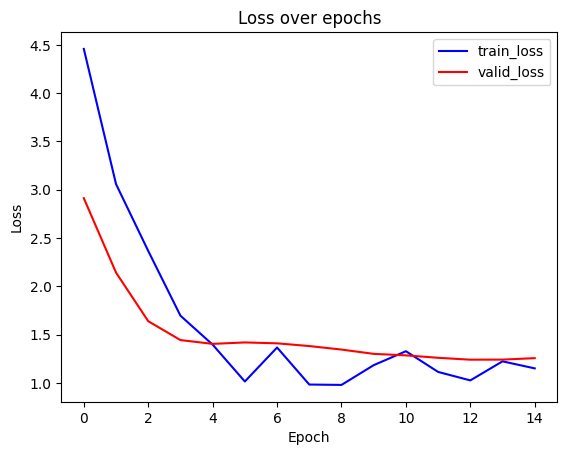

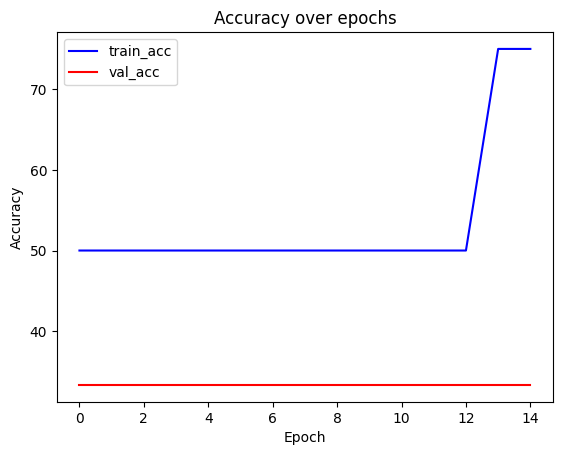

In [17]:
plot_losses(train_losses,valid_losses),plot_accuracy(train_accuracy,val_accuracy)

In [18]:
get_accuracy(model,test_loader,device) # test

50.0

In [5]:

import cv2

def extract_frames(video_path, output_path, frame_rate):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval between frames based on the desired frame rate
    interval = int(video.get(cv2.CAP_PROP_FPS) / frame_rate)

    # Initialize variables
    frame_counter = 0
    elapsed_time = 0

    while True:
        # Read the next frame from the video
        ret, frame = video.read()

        if not ret:
            break

        # Check if the elapsed time exceeds the interval
        if elapsed_time >= interval:
            # Save the frame to the output path
            output_frame_path = output_path + "/frame_{}.jpg".format(frame_counter)
            cv2.imwrite(output_frame_path, frame)
            
            # Reset the elapsed time and increment the frame counter
            elapsed_time = 0
            frame_counter += 1

        # Increment the elapsed time
        elapsed_time += 1

    # Release the video file and close any open windows
    video.release()
    cv2.destroyAllWindows()

# Example usage
video_path = "data/108_new/new_video/Class AS/AS_0_02072023_07.mp4"
output_path = "data/108_new/test"
frame_rate = 250

extract_frames(video_path, output_path, frame_rate)

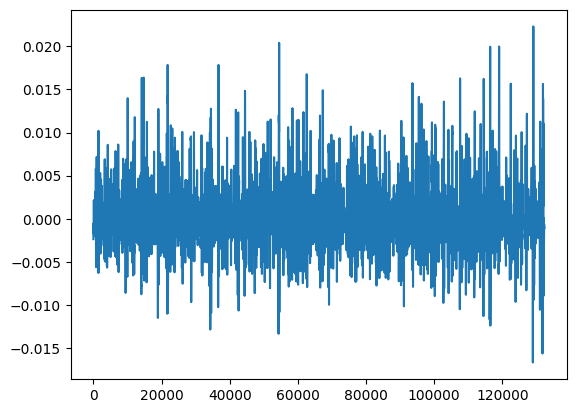

In [2]:
train,train_labels,train_emg = torch.load("data/108_new/train.pkl")
train.shape,train_labels.shape,train_emg.shape
plt.plot(np.array(train_emg[0,:,0]))

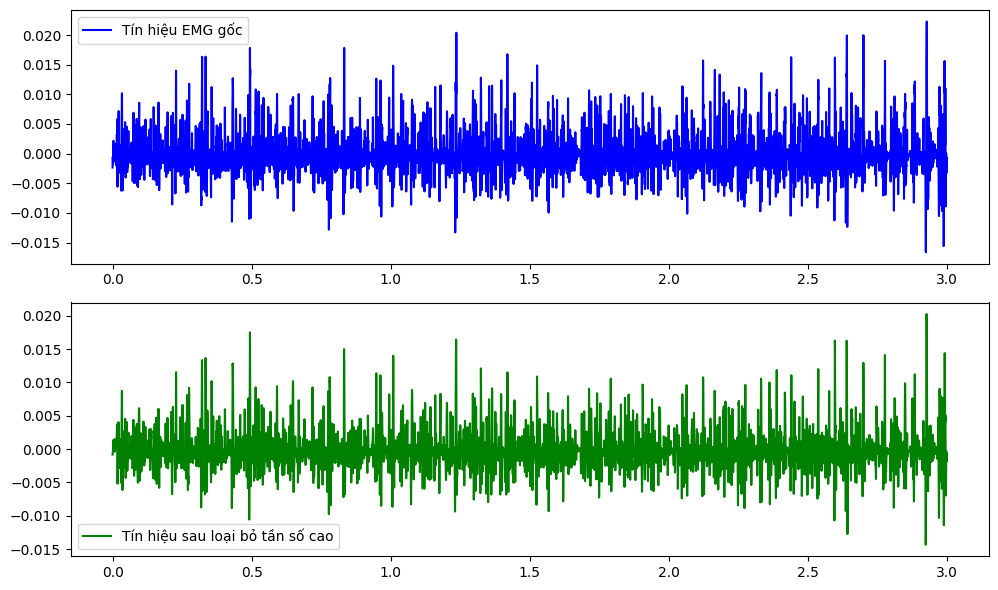

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([ 2.99363040e-04, -4.99374153e-04, -2.66076619e-02,  1.10237192e-02,
        -6.65240807e-03,  3.96493390e-03, -3.29877629e-04, -4.65727110e-06,
         9.21342555e-04, -9.10632379e-04, -1.48050327e-03, -1.30441078e-04,
         2.41026524e-04,  7.56284289e-04,  4.56897571e-04,  3.83651731e-04,
         2.46898781e-04,  5.26237268e-04, -1.30506808e-03, -1.59548779e-03,
        -1.84248190e-04,  1.84615061e-03,  1.80946897e-03,  5.31045896e-04,
        -3.62142063e-04, -9.90452647e-05,  4.79789844e-04, -1.36567678e-03,
        -2.01831270e-03, -7.66824013e-05, -1.38823488e-03, -1.37475887e-03,
         1.25261626e-03, -5.82405174e-04, -2.39264541e-03, -1.17889762e-02,
         1.66711492e-02, -2.91789206e-03,  7.40144623e-04]),
 arra

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Tạo tín hiệu mẫu EMG với biên độ và thời gian
fs = 44100
t = np.arange(0, 3, 1/fs)
emg_signal = np.array(train_emg[0,:,0])

# Chuyển đổi tín hiệu sang miền Wavelet
wavelet = 'db4'  # Chọn loại Wavelet (ví dụ: Daubechies-4)
coeffs = pywt.wavedec(emg_signal, wavelet)

# Tần số cắt cho tín hiệu cao nhất (chọn mức cắt phù hợp)
cutoff_frequency = 450  # Tần số cắt (Hz)

# Tính tần số tương ứng với mức cắt
cutoff_level = int(np.floor(np.log2(cutoff_frequency / fs)))

# Tính tần số tương ứng với mức cắt
cutoff_level1 = int(np.floor(np.log2(20 / fs)))

# Loại bỏ các mức độ biến đổi cao hơn mức cắt
coeffs[cutoff_level+1:] = [np.zeros_like(arr) for arr in coeffs[cutoff_level+1:]]
coeffs[:cutoff_level1] = [np.zeros_like(arr) for arr in coeffs[:cutoff_level1]]
# Chuyển trở lại miền thời gian
emg_filtered = pywt.waverec(coeffs, wavelet)

# Hiển thị tín hiệu gốc và tín hiệu đã lọc
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, emg_signal, 'b', label='Tín hiệu EMG gốc')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(t, emg_filtered, 'g', label='Tín hiệu sau loại bỏ tần số cao')
plt.legend()
plt.tight_layout()
plt.show()
coeffs
